In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Plane(object):
    def __init__(self):
        self.i = None;
        self.a = None; #appearance time
        self.e = None; #earliest
        self.l = None; #latest
        self.t = None; #target
        self.s = [];   #required seperation
        self.g = None; #penalty before
        self.h = None; #penalty after
        
        self.x = -1; #actual landing time
        
    def clone(plane):
        clone = Plane()
        clone.i = plane.i
        clone.a = plane.a
        clone.e = plane.e
        clone.t = plane.t
        clone.l = plane.l
        clone.g = plane.g
        clone.h = plane.h
        clone.s = plane.s[:]
        
        clone.x = plane.x
        
        return clone
    
    def getFitness(self):
        if self.x == self.t:
            return 0
        if self.x > self.t:
            return (self.x - self.t) * self.h
        return (self.t - self.x) * self.g
    
    def __str__(self):
        result = 'appearance time: ' + str(self.a) + '\n' \
                 'earliest: ' + str(self.e) + '\n' \
                 'latest: ' + str(self.l) + '\n' \
                 'target: ' + str(self.t) + '\n' \
                 'penalty before: ' + str(self.g) + '\n' \
                 'penalty after: ' + str(self.h) + '\n' \
                 '--> actual: ' + str(self.x) + '\n' \
                 '--> fitness: ' + str(self.getFitness()) + '\n'
        result += str(self.s) + '\n\n'
        return result

In [3]:
location = './problems/'
prefix = 'airland'
fileType = '.txt'

problemsNumber = 13

problems = []
for i in range(1, problemsNumber + 1):
    problems.append([location + prefix + str(i) + fileType, prefix + str(i)])

In [4]:
problemIndex = 0

problemSetLines = pd.read_csv(problems[problemIndex][0], header=None).values.tolist()

problemSet = []
for line in problemSetLines: 
    problemSet.append(line[0].strip().split(' '))

In [5]:
firstLine = problemSet.pop(0)
P = int(firstLine[0])
Freeze = int(firstLine[1])

P, Freeze

(10, 10)

In [6]:
planeList = []

done = False
planeIndex = 0
while planeIndex < P:
    planeIndex += 1
    props = problemSet.pop(0)
    i = Plane()
    i.i = planeIndex - 1
    i.a = int(props[0]) #appearance time, 
    i.e = int(props[1]) #earliest landing time, 
    i.t = int(props[2]) #target landing time,
    i.l = int(props[3]) #latest landing time, 
    i.g = float(props[4]) #penalty cost per unit of time for landing before target, 
    i.h = float(props[5]) #penalty cost per unit of time for landing after target
    while len(i.s) < P:
        sepTimes = map(int, problemSet.pop(0))
        i.s.extend(sepTimes)
        #separation time required after i lands before j can land
        
    planeList.append(i)

In [7]:
class LandingSolution(object):
    def __init__(self):
        self.landingSolution = None
        self.p = P
        
    def clone(self):
        clone = LandingSolution()
        clone.landingSolution = list(map(Plane.clone, self.landingSolution))
        return clone
        
    def constructRandomSolution(self, planes):
        while not self.valid():
            self.landingSolution = []
            for i, plane in enumerate(planes):
                plane.x = np.random.randint(low=plane.e, high=plane.l + 1)
                self.landingSolution.append(plane)
                
    def valid(self):
        if self.landingSolution == None: return False 
        for i, plane in enumerate(self.landingSolution):
            if plane.x < plane.e or plane.x > plane.l: return False
            for j, seperation in enumerate(plane.s):
                if i == j: continue
                otherPlane = self.landingSolution[j]
                if plane.x <= otherPlane.x and plane.x + seperation >= otherPlane.x:
                    #print(i, plane, "== > ==\n", j, otherPlane)
                    return False
        return True
    
    def getFitness(self):
        sum = 0
        for i in self.landingSolution:
            sum += i.getFitness();
        return sum
    
    def __str__(self):
        result = ''
        for i, plane in enumerate(self.landingSolution):
            result += str(i) + '\n' + str(plane)
        return result

In [8]:
def createPopulation():
    result = []
    for i in range(POPULATION_SIZE):
        solution = LandingSolution()
        solution.constructRandomSolution(list(map(Plane.clone, planeList)))
        result.append(solution)
    return result

In [9]:
def getPopulationFitness(population):
    populationFitness = []
    for idx, individulal in enumerate(population):
        populationFitness.append(individulal.getFitness())
    
    return np.array(populationFitness)

In [10]:
def getPopulationHeuristicFitness(population, solution):
    populationFitness = []
    for idx, individulal in enumerate(population):
        populationFitness.append(individulal.getFitness(solution))
    
    return np.array(populationFitness)

In [11]:
def tournamentSelector(population, tournament_size=5):
    # Make the tournament
    random_indicies = np.random.randint(len(population), size=tournament_size).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])

    # Run the tournament
    fitnesss = getPopulationFitness(tournament)
    
    maxPos = np.argmax(fitnesss, axis=0)
    minPos = np.argmin(fitnesss, axis=0)
    
    return [random_indicies[minPos], fitnesss[minPos]], [random_indicies[maxPos], fitnesss[maxPos]]

In [12]:
def tournamentHeuristicSelector(population, solution, tournament_size=5):
    # Make the tournament
    random_indicies = np.random.randint(len(population), size=tournament_size).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])

    # Run the tournament
    fitnesss = getPopulationHeuristicFitness(tournament, solution)
    
    maxPos = np.argmax(fitnesss, axis=0)
    minPos = np.argmin(fitnesss, axis=0)
    
    return [random_indicies[minPos], fitnesss[minPos]], [random_indicies[maxPos], fitnesss[maxPos]]

In [13]:
def applyHeuristicToSolution(chromosome, solution):
    clone = solution.clone()
    for heuristic in chromosome:
        clone = heuristic(clone)
    return clone

In [14]:
class Chromosome(object):
    def __init__(self, chromosome):
        self.chromosome = chromosome
    def getFitness(self, solution):
        result = applyHeuristicToSolution(self.chromosome, solution)
        return result.getFitness()

In [15]:
import operators

def geneticHeuristicAlgorithm(population, solution):
    newPop = population[:]
    
    for i in range(NUM_MUTATE):
        best, worst = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        newPop[worst[0]] = Chromosome(operators.swap(newPop[best[0]].chromosome))
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentHeuristicSelector(population, solution, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = operators.crossover(newPop[best1[0]].chromosome, newPop[best2[0]].chromosome)
        newPop[worst1[0]] = Chromosome(result1)
        newPop[worst2[0]] = Chromosome(result2)
    
    return newPop

In [16]:
import landingsolutionoperators

def geneticAlgorithm(population):
    newPop = population[:]
    
    for i in range(NUM_MUTATE):    
        best, worst = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        newPop[worst[0]] = landingsolutionoperators.mutate(population[best[0]])
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = landingsolutionoperators.swapCrossover(population[best1[0]], population[best2[0]])
        newPop[worst1[0]] = result1
        newPop[worst2[0]] = result2
    
    return newPop

In [17]:
def generateChromosome(heuristics):
    chromosome = []
    chromosomeLength = np.random.randint(low=MIN_CHROMOSOME_SIZE,high=MAX_CHROMOSOME_SIZE)
    for i in range(chromosomeLength):
        heuristicChoice = np.random.randint(len(heuristics))
        chromosome.append(heuristics[heuristicChoice])
        
    return chromosome


def createHeuristicPopulation(heuristics):
    population = []
    for i in range(POPULATION_SIZE):
        population.append(Chromosome(generateChromosome(heuristics)))

    return population

def printPopulation(population):
    for ind in population:
        print(ind.chromosome)

In [18]:
POPULATION_SIZE = 15

GENERATIONS = 100
TOURNAMENT_SIZE = 3

MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.3

MIN_CHROMOSOME_SIZE = 20
MAX_CHROMOSOME_SIZE = 30

NUM_MUTATE = int(MUTATION_RATE * POPULATION_SIZE)
NUM_CROSSOVER = int(CROSSOVER_RATE * POPULATION_SIZE)
NUM_REPRODUCTION = POPULATION_SIZE - (NUM_MUTATE + NUM_CROSSOVER)

assert NUM_REPRODUCTION >= 0

SAMPLES = 30

REPORT_RATE = 1

import lowlevelheuristics
heuristics = [
    lowlevelheuristics.tryMoveHighestCloseToTarget,
    lowlevelheuristics.tryMoveHighestCloseToTargetReversed,
    lowlevelheuristics.trySwap,
    lowlevelheuristics.trySwapReversed,
    lowlevelheuristics.shiftUp,
    lowlevelheuristics.shiftUpReversed,
    lowlevelheuristics.shiftDown,
    lowlevelheuristics.shiftDownReversed
]

import heuristicselectors
heuristicSelectors = [
    [heuristicselectors.randomHeuristicSelection, "random"]
]

import moveacceptancetechniques
moveAcceptanceTechniques = [
    [moveacceptancetechniques.acceptAll, "accept all moves"],
    [moveacceptancetechniques.acceptIfImproving, "improving moves"],
    [moveacceptancetechniques.acceptIfEqualOrImproving, "equal or improving moves"]
]        

In [19]:
overTimeResult = []
finalResultMean = []
finalResultStd = []
finalResultMin = []
for heuristicSelector in heuristicSelectors:
    for moveAcceptanceTechnique in moveAcceptanceTechniques:
        print(heuristicSelector[1], moveAcceptanceTechnique[1])

        
        samplesOverTimeResult = []
        samplesFinalResult = []
        for sample in range(SAMPLES):
            sampleOverTimeResult = []
            
            solution = LandingSolution()
            solution.constructRandomSolution(list(map(Plane.clone, planeList)))
            best = solution
            for gen in range(GENERATIONS):
                heuristic = heuristicSelector[0](heuristics)
                potentialSolution = heuristic(solution)
                if moveAcceptanceTechnique[0](solution, potentialSolution):
                    solution = potentialSolution
                if moveacceptancetechniques.acceptIfImproving(best, solution):
                    best = solution
                if gen % REPORT_RATE == 0:
                    sampleOverTimeResult.append(best.getFitness())
            
            samplesFinalResult.append(best.getFitness())
            samplesOverTimeResult.append(sampleOverTimeResult)
            
        overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultMean.append([np.mean(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultStd.append([np.std(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])
        finalResultMin.append([np.min(samplesFinalResult), heuristicSelector[1], moveAcceptanceTechnique[1]])

random accept all moves
random improving moves
random equal or improving moves


In [20]:
print('genetic alg')

        
samplesOverTimeResult = []
samplesFinalResult = []
for sample in range(SAMPLES):
    sampleOverTimeResult = []

    population = createPopulation()
    solution = population[0]
    best = population[0]
    for gen in range(GENERATIONS):
        population = geneticAlgorithm(population)
        if gen % REPORT_RATE == 0:
            fitnesss = getPopulationFitness(population)
            min = np.argmin(fitnesss, axis=0)
            solution = population[min]
        if moveacceptancetechniques.acceptIfImproving(best, solution):
            best = solution
        if gen % REPORT_RATE == 0:
            sampleOverTimeResult.append(best.getFitness())

    samplesFinalResult.append(best.getFitness())
    samplesOverTimeResult.append(sampleOverTimeResult)

overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), 'genetic alg', ''])
finalResultMean.append([np.mean(samplesFinalResult), 'genetic alg', ''])
finalResultStd.append([np.std(samplesFinalResult), 'genetic alg', ''])
finalResultMin.append([np.min(samplesFinalResult), 'genetic alg', ''])

genetic alg


In [22]:
print('genetic alg hyper heuristic')
        

samplesOverTimeResult = []
samplesFinalResult = []
for sample in range(SAMPLES):
    sampleOverTimeResult = []

    population = createHeuristicPopulation(heuristics)
    thissolution = LandingSolution()
    thissolution.constructRandomSolution(list(map(Plane.clone, planeList)))
    current = Chromosome(population[0].chromosome.copy())
    best = Chromosome(population[0].chromosome.copy())
    for gen in range(GENERATIONS):
        population = geneticHeuristicAlgorithm(population, thissolution.clone())
        if gen % REPORT_RATE == 0:
            fitnesss = getPopulationHeuristicFitness(population, thissolution.clone())
            min = np.argmin(fitnesss, axis=0)
            current = Chromosome(population[min].chromosome.copy())
        if best.getFitness(thissolution.clone()) > current.getFitness(thissolution.clone()):
            best = Chromosome(current.chromosome.copy())
        if gen % REPORT_RATE == 0:
            sampleOverTimeResult.append(best.getFitness(thissolution.clone()))

    samplesFinalResult.append(best.getFitness(thissolution.clone()))
    samplesOverTimeResult.append(sampleOverTimeResult)

overTimeResult.append([np.mean(samplesOverTimeResult, axis=0), 'genetic alg hyper heuristic', ''])
finalResultMean.append([np.mean(samplesFinalResult), 'genetic alg hyper heuristic', ''])
finalResultStd.append([np.std(samplesFinalResult), 'genetic alg hyper heuristic', ''])
finalResultMin.append([np.min(samplesFinalResult), 'genetic alg hyper heuristic', ''])

genetic alg hyper heuristic


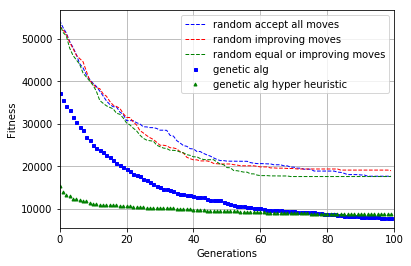

In [30]:
fig = plt.figure()
plt.grid(1)
plt.xlim([0, GENERATIONS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')

generations = np.arange(0, GENERATIONS, REPORT_RATE)

plotColors = [
    'b--',
    'r--',
    'g--',
    'bs',
    'g^',
    'k'
]

plots = []
descriptions = []
for x, result in enumerate(overTimeResult):
    plots.append(plt.plot(generations, result[0], plotColors[x%len(plotColors)] , linewidth=1, markersize=3)[0])
    descriptions.append(result[1] + ' ' + result[2])

plt.legend(plots, descriptions)
fig.savefig('./docs/' + problems[problemIndex][1] + '.png')
plt.show(5)

plt.close()

In [31]:
padding = [None, None, None, None]

problem = []
problem.append(problemIndex + 1)
problem.extend(padding)

d = {
     'problem': problem,
     'type': list(map(lambda x: x[1] + ' ' + x[2], finalResultMean)),
     'mean': list(map(lambda x: x[0], finalResultMean)),
     'std': list(map(lambda x: x[0], finalResultStd)),
     'max': list(map(lambda x: x[0], finalResultMin))
    }

df = pd.DataFrame(data=d)

list(df.columns.values)

result = df[['problem', 'type', 'mean', 'std', 'max']]
result

,problem,type,mean,std,max
0,1.0,random accept all moves,17676.000000,5643.305533,5020.0
1,NaN,random improving moves,18986.000000,6358.833017,6910.0
2,NaN,random equal or improving moves,17599.000000,5807.011480,6570.0
3,NaN,genetic alg,7854.000000,2233.546656,2370.0
4,NaN,genetic alg hyper heuristic,8797.931034,5039.834685,1660.0


In [32]:
#print(result.to_latex(index=False, bold_rows=True, na_rep=''))
with open('./docs/' + problems[problemIndex][1] + '.txt', 'w') as f:
    print(result.to_latex(index=False, bold_rows=True, na_rep=''), file=f)